# Серпов И.В. 18-ИВТ-3
## Лабораторная работа № 2. Методы классификации данных
### Вариант 14
#### Набор данных: 2, Autos
#### Используемые лассификаторы:
- 2 – линейная регрессия, LASSO регуляризатор
- 3 – линейная регрессия, RIDGE регуляризатор


#### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

- dateCrawled - дата первого обхода
- name - название машины
- seller - тип продавца
- offerType: - тип предлоежния
- price - цена автомобиля
- abtest
- vehicleType - тип транспортного средства
- yearOfRegistration - год регистрации
- gearbox - тип коробки передач
- powerPS -  мощность машины в лошадинных силах
- fuelType - тип топлива
- model - модель
- kilometer - пробег автомобиля
- monthOfRegistration - месяц регистрации
- brand - бренд
- notRepairedDamage - наличие повреждений
- dateCreated - дата создяния объявления
- nrOfPictures -  количество фотографий в объявлении
- postalCode - почтовый индекс
- lastSeen - дата последней проверки объявления

Поля lastSeen и dateCreated могут быть использованы для оценки того, как долго объявление автомобиля будет находиться в сети, по крайней мере, пока он не будет продан.

In [92]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr, spearmanr
import sklearn as skl
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
warnings.simplefilter('ignore')

In [93]:
data_base = pd.read_csv("autos.csv", encoding="ISO-8859-1")
data_base.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции.

In [76]:
print("Количество строк и столбцов до обработки:\n", data_base.shape)

Количество строк и столбцов до обработки:
 (371528, 20)


In [77]:
data_base.dropna(inplace=True)
data_base.drop_duplicates(inplace=True)
data_base.drop(['dateCrawled', 'name', 'dateCreated', 'postalCode', 'lastSeen', 'model'], axis = 1, inplace=True)
print("Количество строк и столбцов после обработки:\n", data_base.shape)

Количество строк и столбцов после обработки:
 (260952, 14)


In [78]:
data_base.shape

(260952, 14)

#### 3.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).

In [79]:
numerical_columns = [i for i in data_base.columns if data_base[i].dtype.name != 'object']
print("Numerical: " + str(numerical_columns))

Numerical: ['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration', 'nrOfPictures']


_График до машстабирования:_

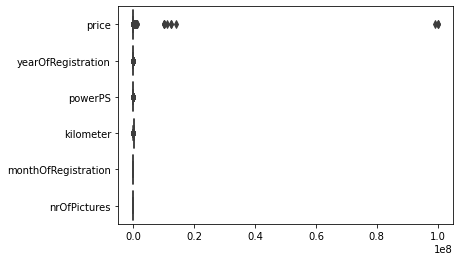

In [80]:
sns.boxplot(data=data_base[numerical_columns], orient="h")
plt.show()

**Масштабирование будем выполнять с помощью нормализации.**

_График после масштабирования:_

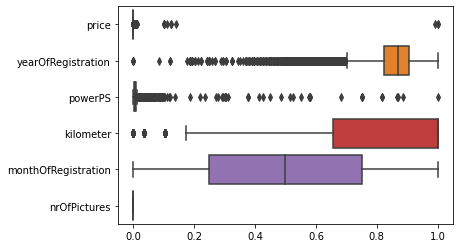

In [81]:
scal = preprocessing.MinMaxScaler()
data_base[numerical_columns] = scal.fit_transform(data_base[numerical_columns])
sns.boxplot(data=data_base[numerical_columns], orient="h")
plt.show()

#### 4.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены.

Категориальные бинарные признаки заменим на 0 и 1.

К небинарным признакам применим dummy-кодирование.

In [82]:
categorical_columns = [i for i in data_base.columns if data_base[i].dtype.name == 'object']
print("Категориальные признаки: " + str(categorical_columns))

Категориальные признаки: ['seller', 'offerType', 'abtest', 'vehicleType', 'gearbox', 'fuelType', 'brand', 'notRepairedDamage']


In [83]:
nonbinary = [column for column in categorical_columns if len(data_base[column].unique()) > 2]

for column in [column for column in categorical_columns if len(data_base[column].unique()) == 2]:
    for i, unic_item in enumerate(data_base[column].unique()):
        data_base[column] = data_base[column].replace(to_replace=[unic_item], value=[i])

db_nonbinary = pd.get_dummies(data_base[nonbinary])
data_base.drop(nonbinary, axis=1, inplace=True)
data_base = pd.concat([db_nonbinary, data_base] , axis=1)
data_base

,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,fuelType_andere,fuelType_benzin,...,offerType,price,abtest,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,notRepairedDamage,nrOfPictures
3,0,0,0,0,1,0,0,0,0,1,...,0,0.000015,0,0.842593,0,0.00375,1.000000,0.500000,0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0,0.000036,0,0.907407,0,0.00345,0.586207,0.583333,0,0.0
5,0,0,0,0,0,0,1,0,0,1,...,0,0.000007,0,0.787037,0,0.00510,1.000000,0.833333,1,0.0
6,0,0,1,0,0,0,0,0,0,1,...,0,0.000022,0,0.870370,0,0.00545,1.000000,0.666667,0,0.0
7,0,0,0,0,0,0,1,0,0,1,...,0,0.000000,0,0.648148,0,0.00250,0.241379,0.583333,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,0,0,0,0,0,0,1,0,0,1,...,0,0.000032,1,0.870370,0,0.01125,1.000000,0.416667,1,0.0
371521,0,1,0,0,0,0,0,0,0,1,...,0,0.000012,1,0.833333,0,0.00000,1.000000,0.250000,0,0.0
371524,0,0,1,0,0,0,0,0,0,1,...,0,0.000012,0,0.833333,1,0.00505,0.827586,0.250000,0,0.0
371525,0,1,0,0,0,0,0,0,0,0,...,0,0.000092,0,0.796296,0,0.00510,1.000000,0.250000,0,0.0


#### 5.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других.

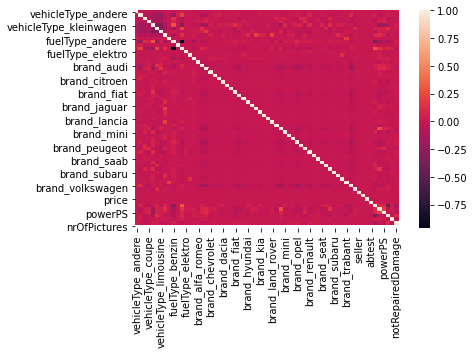

In [84]:
corr_matrix = data_base.corr()
sns.heatmap(corr_matrix)

#### 6.	Заполните пропущенные значения в данных.

In [85]:
data_base.isnull().sum()

vehicleType_andere        0
vehicleType_bus           0
vehicleType_cabrio        0
vehicleType_coupe         0
vehicleType_kleinwagen    0
                         ..
powerPS                   0
kilometer                 0
monthOfRegistration       0
notRepairedDamage         0
nrOfPictures              0
Length: 65, dtype: int64

In [86]:
print("Пропущенных значений в данных нет.")

Пропущенных значений в данных нет.


#### 7.	Решите поставленную задачу регрессии в соответствии с заданием. При подборе параметров метода принятия решения (метода регрессии) используйте перекрёстную проверку (изучите возможные для изменения параметры метода регрессии).  Вычислите точность решения задачи, вычислив разницу между реальным значением и предсказанным. Вычислите коэффициент корреляции (Пирсона, Спирмена) между реальным значением и предсказанным с учётом p-value. 

In [87]:
X, Y = data_base.drop(['price'], axis=1), data_base['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

**Линейная регрессия, LASSO регуляризатор.**

In [88]:
lasso = Lasso()
params = {'alpha': np.arange(0, 0.1, 0.01)}
lasso_grid = GridSearchCV(lasso, params)
lasso_grid.fit(X_train, Y_train)
best_alpha = lasso_grid.best_estimator_.alpha
print('Лучшее значение alpha:', best_alpha)

lasso = Lasso(best_alpha)
lasso.fit(X_train, Y_train)
pred_las = lasso.predict(X_test)
print(pred_las[:15] - y_test[:15])

P, p_value_P = pearsonr(pred_las, Y_test)
print("Коэффициент корреляции Пирсона: ", P)
print("p_value:", p_value_P)
S, p_value_S = spearmanr(pred_las, Y_test)
print("Коэффициент корреляции Спирмена: ", S)
print("p_value:", p_value_S)

Лучшее значение alpha: 0.0
173420   -0.000008
182741   -0.000100
271616   -0.000042
218173    0.000011
361460   -0.000031
45771    -0.000034
297004    0.000044
58119    -0.000008
304305    0.000054
183986   -0.000010
274833    0.000051
346765   -0.000058
237316   -0.000016
107975   -0.000007
241922   -0.000035
Name: price, dtype: float64
Коэффициент корреляции Пирсона:  nan
p_value: nan
Коэффициент корреляции Спирмена:  0.6746674485837861
p_value: 0.0


**Линейная регрессия, RIDGE регуляризатор.**

In [89]:
ridge = Ridge()
params = {'alpha': np.arange(0, 3, 0.05)}
ridge_grid = GridSearchCV(ridge, params)
ridge_grid.fit(X_train, Y_train)
best_alpha = ridge_grid.best_estimator_.alpha
print('Лучшее значение alpha:', best_alpha)

ridge = Ridge(best_alpha)
ridge.fit(X_train, Y_train)
pred_rid = ridge.predict(X_test)
print(pred_rid[:15] - Y_test[:15])

P, p_value_P = pearsonr(pred_las, Y_test)
print("Коэффициент корреляции Пирсона: ", P)
print("p_value:", p_value_P)
S, p_value_S = spearmanr(pred_las, Y_test)
print("Коэффициент корреляции Спирмена: ", S)
print("p_value:", p_value_S)

Лучшее значение alpha: 2.95
173420   -0.000008
182741   -0.000100
271616   -0.000042
218173    0.000011
361460   -0.000031
45771    -0.000033
297004    0.000044
58119    -0.000009
304305    0.000055
183986   -0.000009
274833    0.000050
346765   -0.000058
237316   -0.000016
107975   -0.000006
241922   -0.000034
Name: price, dtype: float64
Коэффициент корреляции Пирсона:  0.014858681019399531
p_value: 3.2165369899616465e-05
Коэффициент корреляции Спирмена:  0.6746674485837861
p_value: 0.0
